##Magnetic Force Simulator

This is a software suite designed to simulate the distribution and forces between fictious "point magnetic charges" as they appear on magnetized surfaces. Limited functionality right now in terms of availible geometries and charge distributions, but can be expanded. There are some improper implementations of inheritance issues which have yet to be fixed.

Plotting of charge distributions and corresponding forces as a function of gaps is made availible via matplotlib. 

Designed by Primus Lam in 2015 for Surgitronic Inc. 

In [1]:
import math

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%run source/magnet_define.py
%run source/magnet_shapes.py

%matplotlib inline

## Charge Distributions

In this simulation, magnets are represented as distribution of charges, fixed in position relative to each other. Source code contains predefined magnet shapes, as well as methods for visualising them in $\mathbb{R}^3$ and computing force vectors between different magnets.

c:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


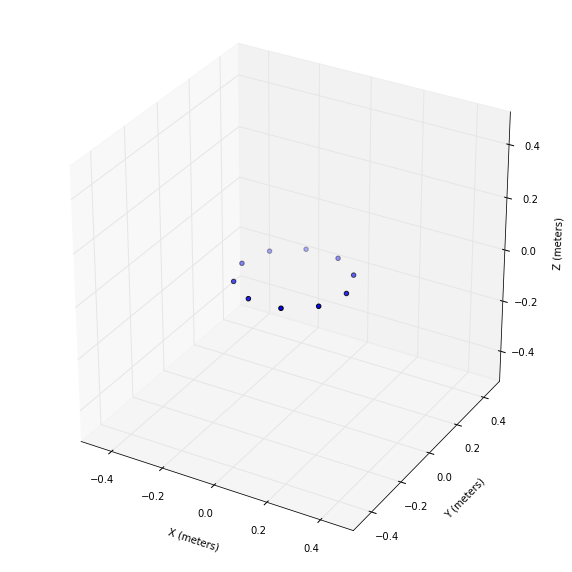

In [2]:
demo_ring = MagnetRing(coor(0, 0, 0), 0.1, 0.3, 0.7, density=10, color='b')
plot_magnet([demo_ring], .5)

c:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


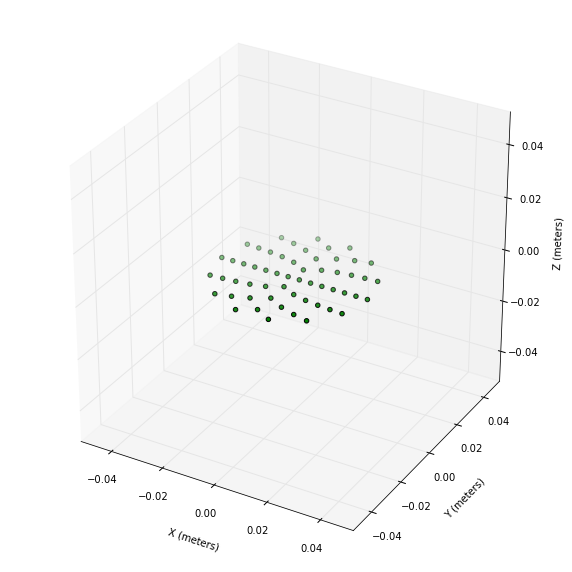

In [3]:
demo_disk = MagnetDisk(coor(0, 0, 0), 0.0, 0.03, 0.7, density=7, color='g')
plot_magnet([demo_disk], .05)

112


c:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


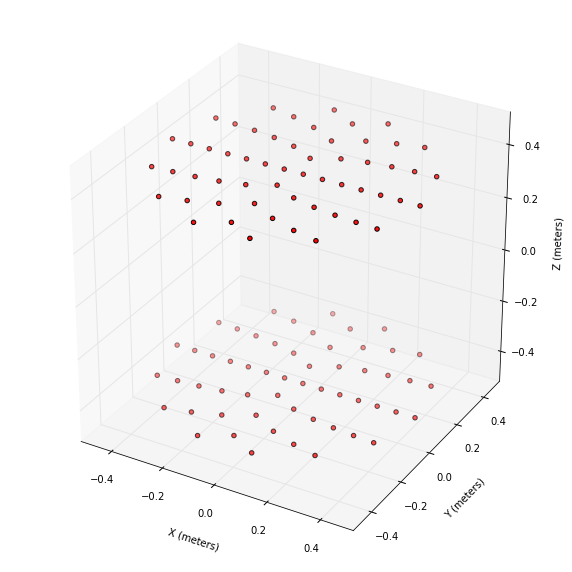

In [4]:
demo_cylinder = MagnetCylinder(coor(0, 0, .4), 0.5, 0.8, 0.05, density=7, color='r')
print(demo_cylinder.size())
plot_magnet([demo_cylinder], .5)

## Combining and Modifying Distributions

It's also possible to combine different magnets or transform and rotate their positions.

c:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


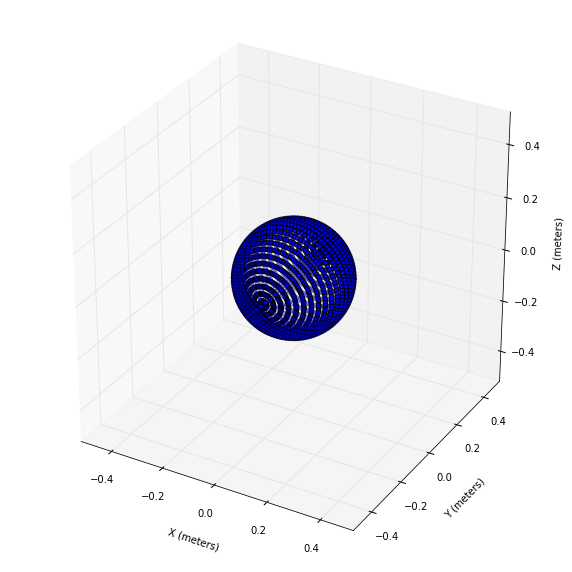

In [5]:
demo_ring1 = MagnetRing(coor(0, 0, 0), 0.1, 0.3, 0.7, density=50, color='b')
plot_magnet([demo_ring1.rotate(coor(0, 0, 0), coor(0, 1, 0), theta) for theta in np.linspace(0, PI, 50)], .5)